#0 - Introdução

**Objetivo**

Visamos desenvolver análise para compreender melhor e prever a ocorrência de churn no contexto de telecon, e assim conseguir auxiliar ao desenvolvimento de estratégias que permitam mitigar churn e, consequentemente, potencializar a receita da empresa.

Também é de nosso interesse responder perguntas tais como:

- Ter dependentes tem impacto no churn?
- O estado civil do cliente impacta o churn?
- Quais tipos de contratos resultam em maior permanencia no serviço da empresa?
- O gênero e idade impactam no churn?

#1 - Bibliotecas

In [ ]:
#Análise de dados
import pandas as pd
import numpy as np
import scipy.stats as norm

#Visualização
import seaborn as sns
import matplotlib.pyplot as plt
#import sweetviz as sv # !pip install sweetviz

#Modelagem
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


## Configurações ##
pd.set_option("max_colwidth", 1000)
pd.options.display.float_format = "{:,.2f}".format
pd.options.plotting.backend = "matplotlib"
plt.style.use("ggplot")


In [ ]:
#Leitura do arquivo contendo os dados
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# 2 - Visão geral e primeiras Inspecções


In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
#Informações sobre as features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
df.shape

(7043, 21)

In [ ]:
#Informação estatística preliminar
df.describe(include="all")

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043,"7,043.00",7043,7043,"7,043.00",7043,7043,7043,7043,...,7043,7043,7043,7043,7043,7043,7043,"7,043.00",7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,6531,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,...,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,NaN,0.16,NaN,NaN,32.37,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.76,NaN,NaN
std,NaN,NaN,0.37,NaN,NaN,24.56,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.09,NaN,NaN
min,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.25,NaN,NaN
25%,NaN,NaN,0.00,NaN,NaN,9.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.50,NaN,NaN
50%,NaN,NaN,0.00,NaN,NaN,29.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.35,NaN,NaN
75%,NaN,NaN,0.00,NaN,NaN,55.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.85,NaN,NaN


In [ ]:
#Verificando para dados faltantes
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
#df['TotalCharges'].replace(" ", "0", inplace=True)
#df['TotalCharges'] = df['TotalCharges'].astype(float)

In [ ]:
#Não são missing exatamente, são 'espaços'. Possível erro de digitação.
df['TotalCharges'].loc[df['TotalCharges'] == ' ']

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object

In [ ]:
df["TotalCharges"].min()

' '

OBSERVAÇÃO: Existe algum valor vazio na feature TotalCharges, a substituição acima resolve o problema, mas ela só será usada depois do split. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


DICIONÁRIO DE DADOS

  

*   CustomerID - ID do cliente
*   gender - Sexo do cliente, F ou M

*   SeniorCitizen - se o cliente é idoso ou não (1 ou 0)
*   Partner - Se o cliente tem parceiro ou não  (1 ou 0)

*   Dependents - Se o cliente tem dependentes ou não (1 ou 0)

*   Tenue - Número de meses que o cliente permaneceu na companhia
*   PhoneService - Se o cliente tem serviço telefônico (Sim ou Não)


*   MultipleLines - Se o cliente tem multiplas linhas ou não (Não, sim ou Sem seviço de telefonia)

*   InternetService - Provedor de internet do cliente (DSL, Fibra optica ou não)

*   OnlineSecurity - Se o cliente tem segurança online ou não (Sim, Não, Sem serviço de internet)
*   OnlineBackup - Se o cliente tem backup online ou não (Sim, Não, Sem serviço de internet)


*   DeviceProtection - Se o cliente tem proteção do dispositivo ou não (Sim, Não, Sem serviço de internet)

*   TechSupport - Se o cliente tem suporte técnico ou não (Sim, Não, Sem serviço de internet)

*   StreamingTV - Se o cliente tem steaming de TV ou não (Yes, No, No internet service)

*   StreamingMovies - Se o cliente tem streaming de filmes ou não (Sim, Não, Sem serviço de internet)
*   Contract - O prazo do contrato do cliente (mês a mês, um ano, dois anos)

*   PaperlessBilling - Se o cliente tem faturamento sem papel ou não (Sim, Não)


*   PaymentMethod - O método de pagamento do cliente (Cheque eletrônico, Cheque enviado, Transferência bancária (automática), Cartão de crédito (automático))


*   MontlyCharges - O valor cobrado do cliente mensalmente
*   TotalCharges - O valor total cobrado do cliente


*   Churn (Target) - Se o cliente se desligou ou não (Sim ou Não)














#2 - Análise exploratória univariada



array([[<Axes: title={'center': 'SeniorCitizen'}>,
        <Axes: title={'center': 'tenure'}>],
       [<Axes: title={'center': 'MonthlyCharges'}>, <Axes: >]],
      dtype=object)

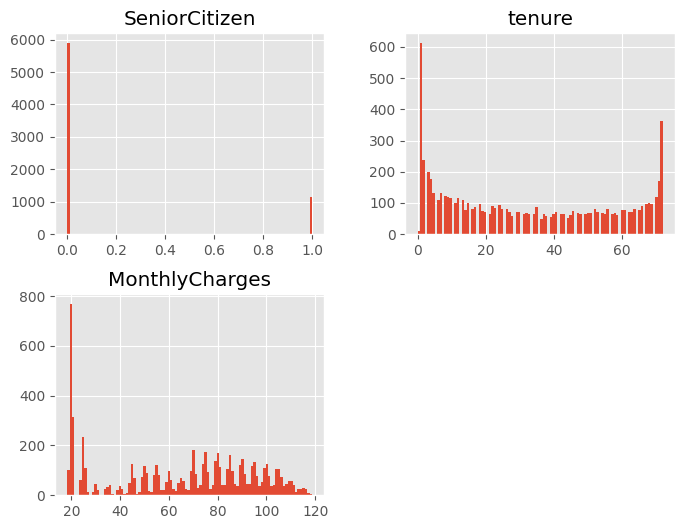

In [ ]:
#Visualisação geral do dataframe
df.hist(bins=100, figsize = [8,6])

Gênero

Sexo dos clientes, masculino ou feminino. Categórico. 

In [ ]:
df["gender"]


0       Female
1         Male
2         Male
3         Male
4       Female
         ...  
7038      Male
7039    Female
7040    Female
7041      Male
7042      Male
Name: gender, Length: 7043, dtype: object

In [ ]:
#Informações gerais
df["gender"].describe()


count     7043
unique       2
top       Male
freq      3555
Name: gender, dtype: object

In [ ]:
#Contagem por gênero
df["gender"].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

([<matplotlib.axis.XTick at 0x7f05ec73c100>,
 [Text(0, 0, 'Masculino'), Text(1, 0, 'Feminino')])

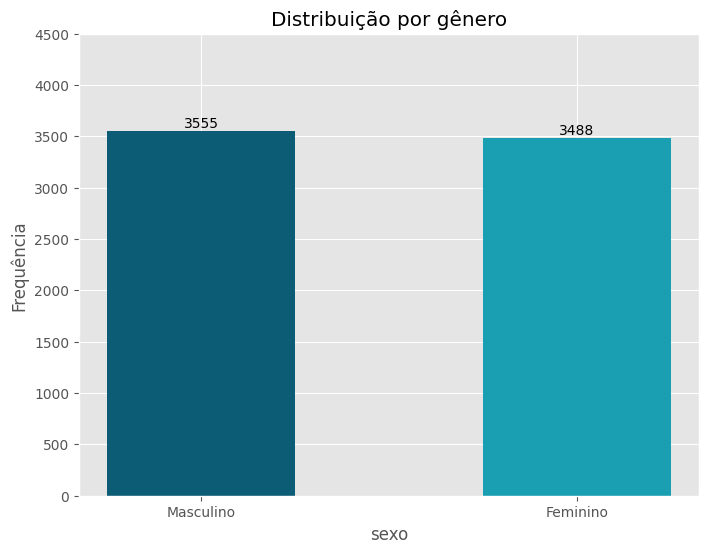

In [ ]:
height = list(df["gender"].value_counts())
x_value = list(df["gender"].value_counts().index)

#plot
bar_width = 0.5
fig, ax = plt.subplots(figsize=[8,6])
bar_plot = ax.bar(x_value, height, bar_width, color=['#0d5c75','#199fb1'])

plt.ylim([0,4500])
plt.bar_label(bar_plot)
plt.title('Distribuição por gênero')
plt.xlabel('sexo')
plt.ylabel('Frequência')
plt.xticks(np.arange(2),['Masculino', 'Feminino'])


A distribuição de gênero parece balanceada nos dados presentes.

#Idosos

Se é idoso ou não (1 ou 0). Variável categórica.

In [ ]:
df["SeniorCitizen"]

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: SeniorCitizen, Length: 7043, dtype: int64

In [ ]:
df["SeniorCitizen"].dtypes

dtype('int64')

In [ ]:
#contagem de clientes idosos
df["SeniorCitizen"].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

([<matplotlib.axis.XTick at 0x7f05ec6b3a30>,
 [Text(0, 0, 'Não-idoso'), Text(1, 0, 'Idoso')])

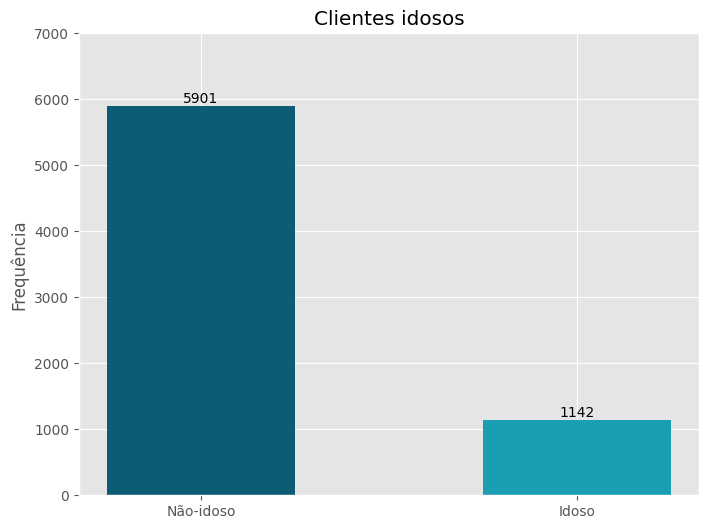

In [ ]:
height = list(df["SeniorCitizen"].value_counts())
x_value = list(df["SeniorCitizen"].value_counts().index)

#plot
bar_width = 0.5
fig, ax = plt.subplots(figsize=[8,6])
bar_plot = ax.bar(x_value, height, bar_width, color=['#0d5c75','#199fb1'])

plt.bar_label(bar_plot)
plt.ylim([0, 7000])
plt.title('Clientes idosos')
plt.ylabel('Frequência')
plt.xticks(np.arange(2), ['Não-idoso', 'Idoso'])



Temos 5901 clientes não-idosos e 1142 idosos, os quais representam ~16% dos clientes.

#Parceiro

Se o cliente tem, ou não, parceiro (yes ou no). Variável categórica.

Hipótese: ter parceiro influencia o churn. (explorado na análise multivariada)

In [ ]:
df["Partner"]

0       Yes
1        No
2        No
3        No
4        No
       ... 
7038    Yes
7039    Yes
7040    Yes
7041    Yes
7042     No
Name: Partner, Length: 7043, dtype: object

In [ ]:
#Informações gerais
df["Partner"].describe()

count     7043
unique       2
top         No
freq      3641
Name: Partner, dtype: object

Maior ocorrência de clientes solteiros.

In [ ]:
#Contagem de clientes com parceiro
cont_parceiros = df["Partner"].value_counts()

Text(0, 0.5, 'frequência')

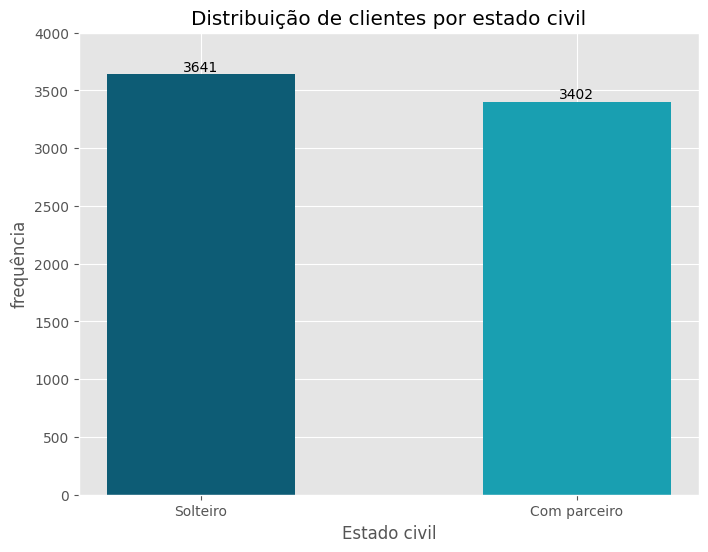

In [ ]:
bar_altura = list(cont_parceiros)
x_valores = list(cont_parceiros.index)

#plot 
bar_larg = 0.5
fig, ax = plt.subplots(figsize=[8,6])
bar_plot = ax.bar(x_valores, bar_altura, bar_larg, color=['#0d5c75','#199fb1'])

plt.bar_label(bar_plot)
plt.ylim([0,4000])
plt.title('Distribuição de clientes por estado civil')
plt.xticks(np.arange(2), ['Solteiro', 'Com parceiro']) #mudando o rótulos dos valores xplt.xlabel('Estado civil')
plt.xlabel('Estado civil')
plt.ylabel('frequência')

A distribuição de clientes com parceiro é bem balanceada.


#Dependents

Se o cliente tem dependentes ou não (1 ou 0). Variável categórica.

**Hipótese**: ter ou não dependentes influencia o churn. (explorado na análise bivariada).

In [ ]:
df['Dependents']

0        No
1        No
2        No
3        No
4        No
       ... 
7038    Yes
7039    Yes
7040    Yes
7041     No
7042     No
Name: Dependents, Length: 7043, dtype: object

In [ ]:
#estatísticas básicas
df['Dependents'].describe()

count     7043
unique       2
top         No
freq      4933
Name: Dependents, dtype: object

In [ ]:
#contagem de clientes com dependentes
cont_depend = df['Dependents'].value_counts()
cont_depend

No     4933
Yes    2110
Name: Dependents, dtype: int64

Text(0, 0.5, 'frequência')

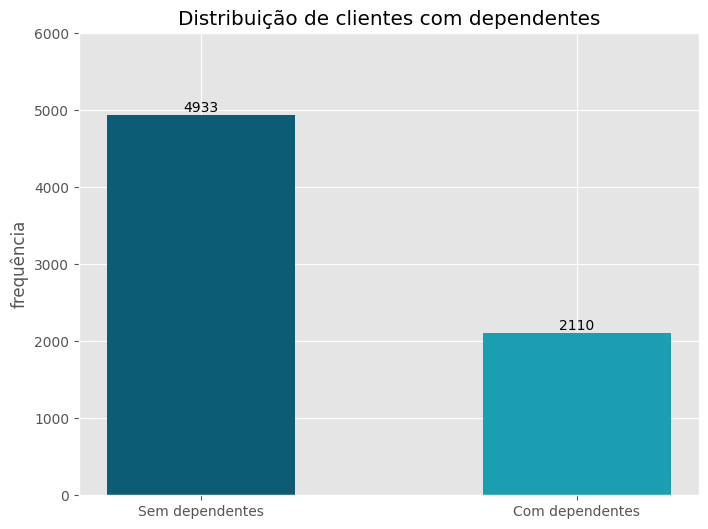

In [ ]:
#plotando
bar_altura_depend = list(cont_depend)
x_valores_depend = list(cont_depend.index)

#barras
bar_larg = 0.5
fig, ax = plt.subplots(figsize=[8,6])
bar_plot_depend = ax.bar(x_valores_depend, bar_altura_depend, bar_larg, color=['#0d5c75','#199fb1'])

plt.bar_label(bar_plot_depend)
plt.ylim([0,6000])
plt.title('Distribuição de clientes com dependentes')
plt.xticks(np.arange(2), ['Sem dependentes', 'Com dependentes']) #mudando o rótulos dos valores x
plt.ylabel('frequência')

Há uma diferença considerável entre clientes com dependentes e sem.

#Tenure

Número de meses que o cliente permaneceu na companhia - variável discreta numérica. 

Obs: diretamente relacionada com a variável contract.

In [ ]:
df['tenure']

0        1
1       34
2        2
3       45
4        2
        ..
7038    24
7039    72
7040    11
7041     4
7042    66
Name: tenure, Length: 7043, dtype: int64

In [ ]:
#Estatística báscia da feature
df['tenure'].describe()

count   7,043.00
mean       32.37
std        24.56
min         0.00
25%         9.00
50%        29.00
75%        55.00
max        72.00
Name: tenure, dtype: float64

Clientes permanecem em média 32 meses no serviço. O que equivale a aproximadamente 2,6 anos.

Text(0.5, 0, 'Meses')

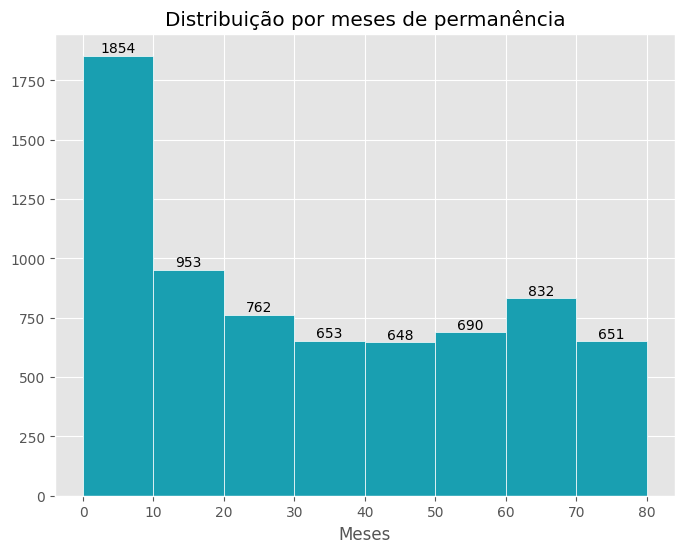

In [ ]:
#Plotando
plt.figure(figsize = [8,6])
bins = [0,10,20,30,40,50,60,70,80]
counts, edges, bars = plt.hist(df.tenure, bins = bins,
                               edgecolor = 'white', color = ['#199fb1'])

plt.bar_label(bars)

plt.title('Distribuição por meses de permanência')
plt.xlabel('Meses')

In [ ]:
#Quantos ocorrências de até 1 mês?
df["tenure"].loc[df["tenure"] == 1].count()

613

Ao menos 624 clientes ficaram apenas 1 mês ou menos na empresa.

In [ ]:
#E mais de 1 ano?
df["tenure"].loc[df["tenure"] >= 12].count()

4974

4974 clientes ficaram ao menos 1 ano no serviço. 

Aparentemente a contagem contínua dos meses de permanência pode não ser suficiente por si, uma vez que os clientes estão sujeitos a três tipos específicos de contratos, as duas features parecem ser melhor entendidas juntas.

In [ ]:
df["tenure"].loc[df["tenure"] == 72].count()

362

362 clientes permaneceram (até a data de coleta dos dados) 72 meses no serviço, o que equivale a 6 anos. São clientes já fidelizados.

Pergunta: 

Qual a porcentagem de clientes com mais de 2 anos? 

In [ ]:
#porcentagem de clientes há mais de 2 anos com a empresa
client_count_2anos = df["tenure"].loc[df["tenure"] >= 24].count()
client_count_2anos

3927

In [ ]:
porcent_client_2anos = (client_count_2anos/df["customerID"].count())*100
porcent_client_2anos

55.75748970609116

55.7% dos clientes no conjunto de dados permaneceram 2 anos ou mais na empresa. 


#PhoneService

Se o cliente tem serviço telefônico (Sim ou Não). Categórica.

In [ ]:
df["PhoneService"]

0        No
1       Yes
2       Yes
3        No
4       Yes
       ... 
7038    Yes
7039    Yes
7040     No
7041    Yes
7042    Yes
Name: PhoneService, Length: 7043, dtype: object

In [ ]:
#Estatística básica
df["PhoneService"].describe()

count     7043
unique       2
top        Yes
freq      6361
Name: PhoneService, dtype: object

Uma parcela consideravelmente maior dos clientes têm serviço de telefonia.

In [ ]:
#90% dos clientes têm serviço de telefonia
PhoneService_count = df["PhoneService"].value_counts()

([<matplotlib.axis.XTick at 0x7f05ec4a52b0>,
 [Text(0, 0, 'Sim'), Text(1, 0, 'Não')])

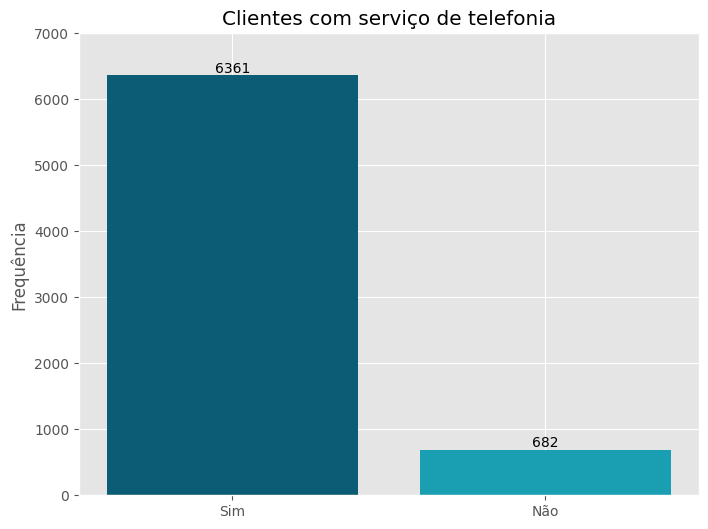

In [ ]:
#plot
bar_alt_phoneservice = list(PhoneService_count)
x_valores_phoneservice = list(PhoneService_count.index)

#barras
bar_larg = 0.3
fig, ax = plt.subplots(figsize = [8,6])
bar_plot = ax.bar(x_valores_phoneservice, bar_alt_phoneservice, color=['#0d5c75','#199fb1'])

#rótulos
plt.bar_label(bar_plot)
plt.ylim(0,7000)
plt.title("Clientes com serviço de telefonia")
plt.ylabel("Frequência")
plt.xticks(np.arange(2), ['Sim', 'Não'])

#MultipleLines

Se o cliente tem multiplas linhas ou não (Não, sim ou Sem seviço de telefonia). Variável categórica.

In [ ]:
df["MultipleLines"]

0       No phone service
1                     No
2                     No
3       No phone service
4                     No
              ...       
7038                 Yes
7039                 Yes
7040    No phone service
7041                 Yes
7042                  No
Name: MultipleLines, Length: 7043, dtype: object

In [ ]:
df["MultipleLines"].describe()

count     7043
unique       3
top         No
freq      3390
Name: MultipleLines, dtype: object

In [ ]:
multiplelines_count = df["MultipleLines"].value_counts()

([<matplotlib.axis.XTick at 0x7f05ec48f4c0>,
 [Text(0, 0, 'Não'), Text(1, 0, 'Sim'), Text(2, 0, 'Sem telefone')])

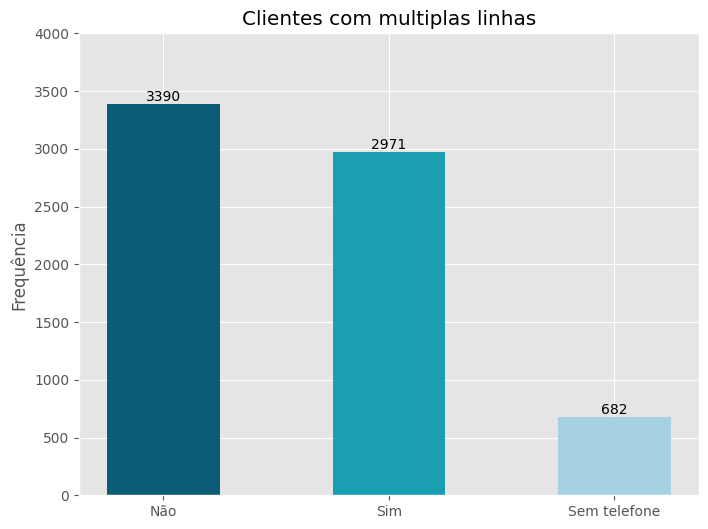

In [ ]:
#plot
bar_alt_multiplelines = list(multiplelines_count)
x_valores_multiplelines = list(multiplelines_count.index)

#barras
bar_larg = 0.5
fig, ax = plt.subplots(figsize = [8,6])
bar_plot = ax.bar(x_valores_multiplelines, bar_alt_multiplelines, 
                  bar_larg, color = ['#0d5c75', '#199fb1', '#a5d1e1'])

#rótulos
plt.bar_label(bar_plot)
plt.title('Clientes com multiplas linhas')
plt.ylim(0,4000)
plt.ylabel('Frequência')
plt.xticks(np.arange(3),['Não', 'Sim','Sem telefone']) #mudando rótulos dos Xs

#InternetService 

Provedor de internet do cliente (DSL, Fibra optica ou não). Variável categórica. 

In [ ]:
df['InternetService']

0               DSL
1               DSL
2               DSL
3               DSL
4       Fiber optic
           ...     
7038            DSL
7039    Fiber optic
7040            DSL
7041    Fiber optic
7042    Fiber optic
Name: InternetService, Length: 7043, dtype: object

In [ ]:
df['InternetService'].describe()

count            7043
unique              3
top       Fiber optic
freq             3096
Name: InternetService, dtype: object

In [ ]:
#valores únicos
df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [ ]:
#Porcentagem
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

Maior parte dos clientes (3096, ou seja, 44%) tem serviço de internet por fibra óptica, consideravelmente maior que DSL.

In [ ]:
#contagem
count_inter_service = df['InternetService'].value_counts()

([<matplotlib.axis.XTick at 0x7f05ec408340>,
 [Text(0, 0, 'Fibra óptica'), Text(1, 0, 'DSL'), Text(2, 0, 'Não')])

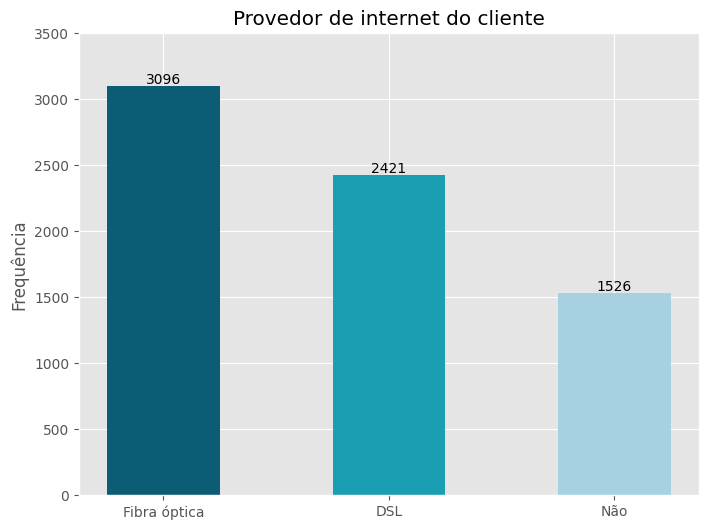

In [ ]:
#plot
bar_alt_inter_service = list(count_inter_service)
x_valores_inter_service = list(count_inter_service.index)

#barras
bar_larg = 0.5
fig, ax = plt.subplots(figsize=[8,6])
bar_plot = ax.bar(x_valores_inter_service, bar_alt_inter_service,
                  bar_larg, color = ['#0d5c75', '#199fb1', '#a5d1e1'])

#rótulos
plt.bar_label(bar_plot)
plt.ylim(0,3500)
plt.title('Provedor de internet do cliente')
plt.ylabel('Frequência')
plt.xticks(np.arange(3), ['Fibra óptica', 'DSL', 'Não'])

#OnlineSecurity

Se o cliente tem segurança online ou não (Sim, Não, Sem serviço de internet). Variável categórica.

In [ ]:
df["OnlineSecurity"]

0        No
1       Yes
2       Yes
3       Yes
4        No
       ... 
7038    Yes
7039     No
7040    Yes
7041     No
7042    Yes
Name: OnlineSecurity, Length: 7043, dtype: object

In [ ]:
df["OnlineSecurity"].describe()

count     7043
unique       3
top         No
freq      3498
Name: OnlineSecurity, dtype: object

In [ ]:
#elementos únicos na feature
df["OnlineSecurity"].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

Maioria dos clientes não tem serviço de segurança online.

In [ ]:
count_onlinesec = df["OnlineSecurity"].value_counts()
count_onlinesec

No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64

([<matplotlib.axis.XTick at 0x7f05ecc0bbb0>,
 [Text(0, 0, 'Não'), Text(1, 0, 'Sim'), Text(2, 0, 'Sem internet')])

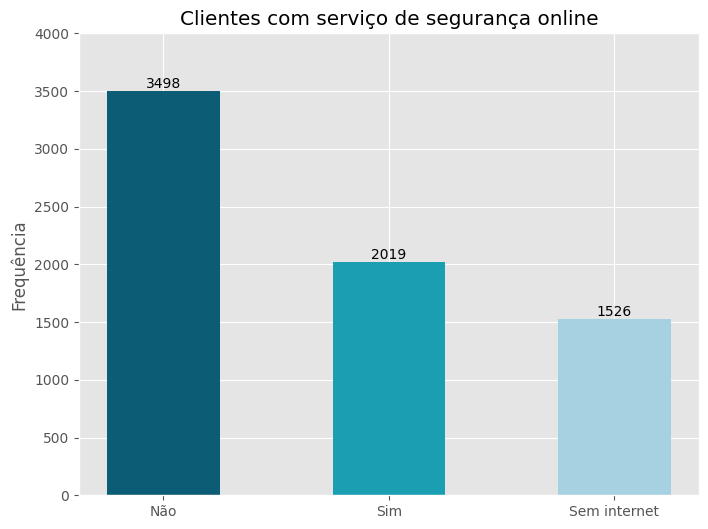

In [ ]:
#plot
bar_alt_onlinesec = list(count_onlinesec)
x_valores_onlinesec = list(count_onlinesec.index)

#barras 
bar_larg = 0.5
fig, ax = plt.subplots(figsize = [8,6])
bar_plot = ax.bar(x_valores_onlinesec, bar_alt_onlinesec,
                  bar_larg, color = ['#0d5c75', '#199fb1', '#a5d1e1'])

#rótulos
plt.bar_label(bar_plot)
plt.ylim(0,4000)
plt.title("Clientes com serviço de segurança online")
plt.ylabel("Frequência")
plt.xticks(np.arange(3), ["Não","Sim", "Sem internet"])
                  

Serviço de segurança online não é algo popular entre os clientes. 

#OnlineBackup

 OnlineBackup - Se o cliente tem backup online ou não (Sim, Não, Sem serviço de internet).

In [ ]:
df["OnlineBackup"]

0       Yes
1        No
2       Yes
3        No
4        No
       ... 
7038     No
7039    Yes
7040     No
7041     No
7042     No
Name: OnlineBackup, Length: 7043, dtype: object

In [ ]:
df["OnlineBackup"].describe()

count     7043
unique       3
top         No
freq      3088
Name: OnlineBackup, dtype: object

Resultados bastante parecidos com o caso de segurança online, aparentemente também não é um serviço popular entre clientes.

In [ ]:
df["OnlineBackup"].unique()

array(['Yes', 'No', 'No internet service'], dtype=object)

In [ ]:
count_backup = df["OnlineBackup"].value_counts()
count_backup 

No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64

([<matplotlib.axis.XTick at 0x7f05ecc66d90>,
 [Text(0, 0, 'Não'), Text(1, 0, 'Sim'), Text(2, 0, 'Sem internet')])

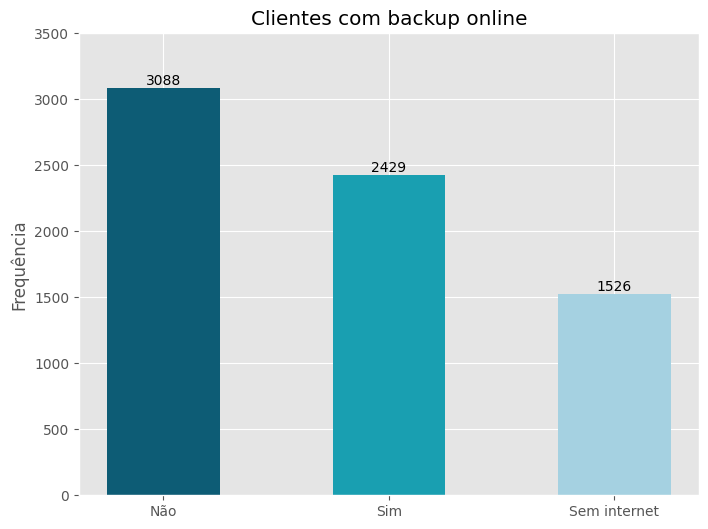

In [ ]:
#plot
bar_alt_backup = list(count_backup)
x_valores_backup = list(count_backup.index)

#barras 
bar_larg = 0.5
fig, ax = plt.subplots(figsize = [8,6])
bar_plot = ax.bar(x_valores_backup, bar_alt_backup,
                  bar_larg, color = ['#0d5c75', '#199fb1', '#a5d1e1'])

#rótulos
plt.bar_label(bar_plot)
plt.ylim(0,3500)
plt.title("Clientes com backup online")
plt.ylabel("Frequência")
plt.xticks(np.arange(3), ["Não","Sim", "Sem internet"])

Apesar de ainda uma maioria não ter serviço de backup, é ele mais popular entre os clientes que o serviço de segurança online. 

#DeviceProtection

DeviceProtection - Se o cliente tem proteção do dispositivo ou não (Sim, Não, Sem serviço de internet). Variável categórica.

In [ ]:
df["DeviceProtection"]

0        No
1       Yes
2        No
3       Yes
4        No
       ... 
7038    Yes
7039    Yes
7040     No
7041     No
7042    Yes
Name: DeviceProtection, Length: 7043, dtype: object

In [ ]:
df["DeviceProtection"].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

Mais uma feature com 'no internet service', provavelmente todas as features relativas a segurança do cliente terão.

In [ ]:
df["DeviceProtection"].describe()

count     7043
unique       3
top         No
freq      3095
Name: DeviceProtection, dtype: object

In [ ]:
#porcentagem
count_dev_protec = df["DeviceProtection"].value_counts()
count_dev_protec

No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64

([<matplotlib.axis.XTick at 0x7f05ecd64820>,
 [Text(0, 0, 'Não'), Text(1, 0, 'Sim'), Text(2, 0, 'Sem internet')])

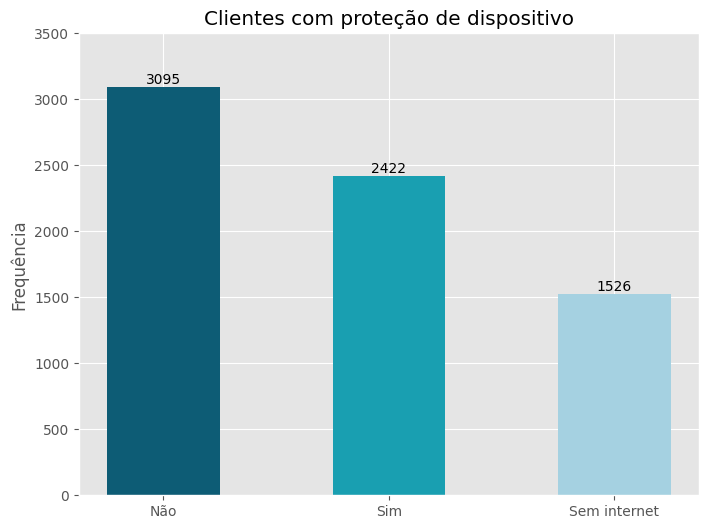

In [ ]:
#plot
bar_alt_dev_protec = list(count_dev_protec)
x_valores_dev_protec = list(count_dev_protec.index)

#barras 
bar_larg = 0.5
fig, ax = plt.subplots(figsize = [8,6])
bar_plot = ax.bar(x_valores_dev_protec, bar_alt_dev_protec,
                  bar_larg, color = ['#0d5c75', '#199fb1', '#a5d1e1'])

#rótulos
plt.bar_label(bar_plot)
plt.ylim(0,3500)
plt.title("Clientes com proteção de dispositivo")
plt.ylabel("Frequência")
plt.xticks(np.arange(3), ["Não","Sim", "Sem internet"])

#TechSupport

Se o cliente tem suporte técnico ou não (Sim, Não, Sem serviço de internet). Variável categórica.

In [ ]:
df["TechSupport"]

0        No
1        No
2        No
3       Yes
4        No
       ... 
7038    Yes
7039     No
7040     No
7041     No
7042    Yes
Name: TechSupport, Length: 7043, dtype: object

In [ ]:
#valores únicos
df["TechSupport"].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [ ]:
#estatística geral
df["TechSupport"].describe()

count     7043
unique       3
top         No
freq      3473
Name: TechSupport, dtype: object

A maioria dos clientes não assina suporte técnico. Aparentemente é uma tendência no que diz respeito a serviços de segurança.

In [ ]:
#contagem
count_Tech_Sup = df["TechSupport"].value_counts()
count_Tech_Sup

No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64

([<matplotlib.axis.XTick at 0x7f05edbb3790>,
 [Text(0, 0, 'Não'), Text(1, 0, 'Sim'), Text(2, 0, 'Sem internet')])

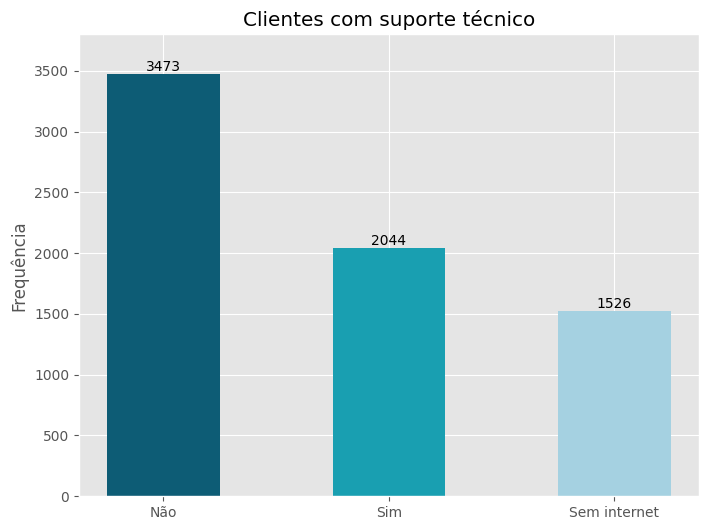

In [ ]:
#plot
bar_alt_Tech_Sup = list(count_Tech_Sup)
x_valores_Tech_Sup = list(count_Tech_Sup.index)

#barras 
bar_larg = 0.5
fig, ax = plt.subplots(figsize = [8,6])
bar_plot = ax.bar(x_valores_Tech_Sup, bar_alt_Tech_Sup,
                  bar_larg, color = ['#0d5c75', '#199fb1', '#a5d1e1'])

#rótulos
plt.bar_label(bar_plot)
plt.ylim(0,3800)
plt.title("Clientes com suporte técnico")
plt.ylabel("Frequência")
plt.xticks(np.arange(3), ["Não","Sim", "Sem internet"])

Os serviços de segurança são bastante presentes entre os clientes, mas em todos os casos (tipos de serviços de segurança) a norma é não tê-los. Talvez oferecer algum tipo de serviço de segurança em conjunto seja uma estratégia interessante. A análise bivariada poderá produzir melhores insights.

##StreamingTV

 Se o cliente tem steaming de TV ou não (Yes, No, No internet service). Variável categórica.

In [ ]:
df["StreamingTV"]

0        No
1        No
2        No
3        No
4        No
       ... 
7038    Yes
7039    Yes
7040     No
7041     No
7042    Yes
Name: StreamingTV, Length: 7043, dtype: object

In [ ]:
#valores únicos
df["StreamingTV"].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [ ]:
#porcentagem
count_streaming = df["StreamingTV"].value_counts()
count_streaming

No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64

([<matplotlib.axis.XTick at 0x7f05ec4d2340>,
 [Text(0, 0, 'Não'), Text(1, 0, 'Sim'), Text(2, 0, 'Sem serviço de internet')])

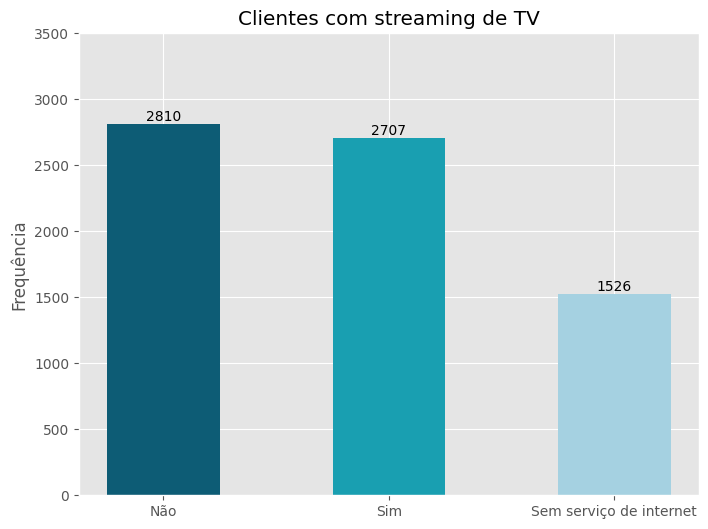

In [ ]:
#Plot
bar_alt_streaming = list(count_streaming)
x_valores_streaming = list(count_streaming.index)

#Barras
bar_larg = 0.5
fig, ax = plt.subplots(figsize = [8,6])
bar_plot = ax.bar(x_valores_streaming, bar_alt_streaming,
                  bar_larg, color = ['#0d5c75', '#199fb1', '#a5d1e1'] )

#rótulos
plt.title("Clientes com streaming de TV")
plt.ylim(0, 3500)
plt.ylabel("Frequência")
plt.bar_label(bar_plot)
plt.xticks(np.arange(3), ["Não","Sim", "Sem serviço de internet"])

Streaming de tv é um serviço popular dentre os clientes. 

##Streaming Movies

Se o cliente tem streaming de filmes ou não (Sim, Não, Sem serviço de internet).Variável categórica.

In [ ]:
df["StreamingMovies"]

0        No
1        No
2        No
3        No
4        No
       ... 
7038    Yes
7039    Yes
7040     No
7041     No
7042    Yes
Name: StreamingMovies, Length: 7043, dtype: object

In [ ]:
#info estatísticas gerais
df["StreamingMovies"].describe()

count     7043
unique       3
top         No
freq      2785
Name: StreamingMovies, dtype: object

In [ ]:
df["StreamingMovies"].unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [ ]:
#contagem
count_streaming_M = df["StreamingMovies"].value_counts()
count_streaming_M

No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64

([<matplotlib.axis.XTick at 0x7f05edc2e610>,
 [Text(0, 0, 'Não'), Text(1, 0, 'Sim'), Text(2, 0, 'Sem serviço de internet')])

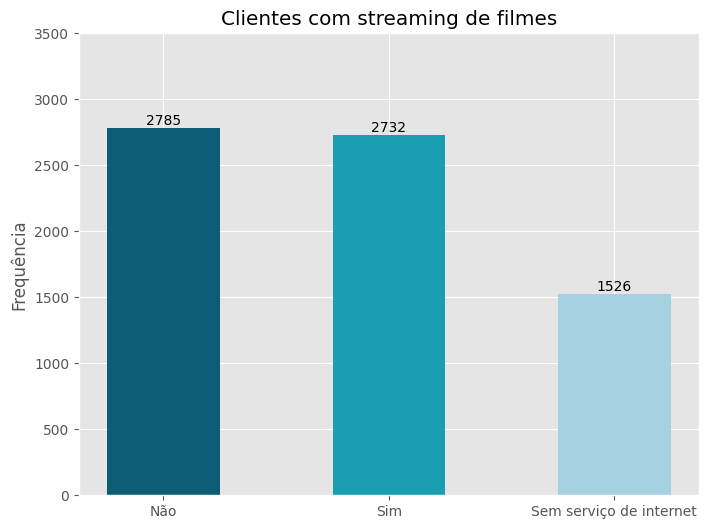

In [ ]:
#Plot
bar_alt_streaming_M = list(count_streaming_M)
x_valores_streaming_M = list(count_streaming_M.index)

#Barras
bar_larg = 0.5
fig, ax = plt.subplots(figsize = [8,6])
bar_plot = ax.bar(x_valores_streaming_M, bar_alt_streaming_M,
                  bar_larg, color = ['#0d5c75', '#199fb1', '#a5d1e1'] )

#rótulos
plt.title("Clientes com streaming de filmes")
plt.ylim(0, 3500)
plt.ylabel("Frequência")
plt.bar_label(bar_plot)
plt.xticks(np.arange(3), ["Não","Sim", "Sem serviço de internet"])

Praticamente metade dos clientes com serviço de internet assinam serviço de streaming de filmes.

Serviços de streaming tanto de TV quanto de filmes são bastante populares entre os clientes de modo que ~50% dos clientes com internet têm serviços de streaming.

##Contract

O prazo do contrato do cliente (mês a mês, um ano, dois anos). Variável categórica.

In [ ]:
df["Contract"]

0       Month-to-month
1             One year
2       Month-to-month
3             One year
4       Month-to-month
             ...      
7038          One year
7039          One year
7040    Month-to-month
7041    Month-to-month
7042          Two year
Name: Contract, Length: 7043, dtype: object

In [ ]:
#Estatística geral
df["Contract"].describe()

count               7043
unique                 3
top       Month-to-month
freq                3875
Name: Contract, dtype: object

In [ ]:
df["Contract"].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [ ]:
#sem dados nulos
df["Contract"].isnull().sum()

0

In [ ]:
count_contract = df["Contract"].value_counts()
count_contract

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

([<matplotlib.axis.XTick at 0x7f05ed7acc10>,
 [Text(0, 0, 'Mensal'), Text(1, 0, 'Bianual'), Text(2, 0, 'Anual')])

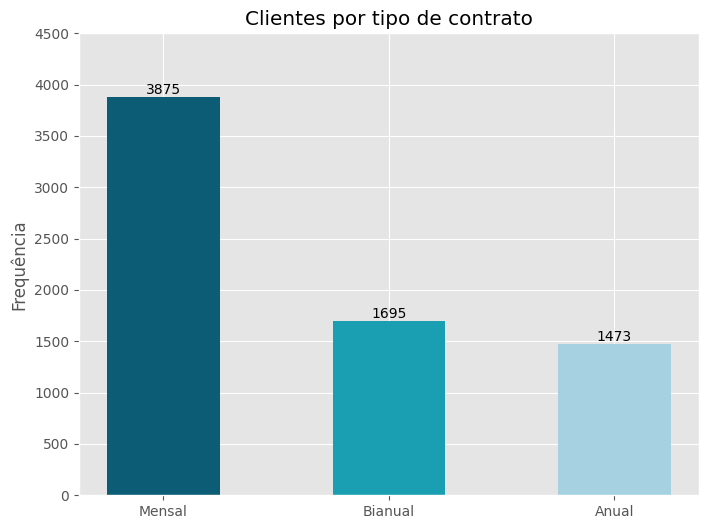

In [ ]:
#Plot
bar_alt_count_contract = list(count_contract)
x_valores_count_contract = list(count_contract.index)

#Barras
bar_larg = 0.5
fig, ax = plt.subplots(figsize = [8,6])
bar_plot = ax.bar(x_valores_count_contract, bar_alt_count_contract,
                  bar_larg, color = ['#0d5c75', '#199fb1', '#a5d1e1'] )

#rótulos
plt.title("Clientes por tipo de contrato")
plt.ylim(0, 4500)
plt.ylabel("Frequência")
plt.bar_label(bar_plot)
plt.xticks(np.arange(3), ["Mensal","Bianual", "Anual"])




Contratos mensais (mês a mês) são aparentemente muito preferidos pelos clientes. 

**Pergunta**: Isso indica ocorrência de clientes novos conhecendo o serviço ou é uma preferência até entre clientes já fidelizados?

#PaperlessBilling

 Se o cliente tem faturamento sem papel ou não (Sim, Não).

In [ ]:
df["PaperlessBilling"]

0       Yes
1        No
2       Yes
3        No
4       Yes
       ... 
7038    Yes
7039    Yes
7040    Yes
7041    Yes
7042    Yes
Name: PaperlessBilling, Length: 7043, dtype: object

In [ ]:
df["PaperlessBilling"].describe()

count     7043
unique       2
top        Yes
freq      4171
Name: PaperlessBilling, dtype: object

In [ ]:
#Porcentagem
df["PaperlessBilling"].value_counts(1)

Yes   0.59
No    0.41
Name: PaperlessBilling, dtype: float64

Aproximandamente metade dos clientes têm fatura sem papel (digital).

##PaymentMethod

O método de pagamento do cliente (Cheque eletrônico, Cheque enviado, Transferência bancária (automática), Cartão de crédito (automático)).

In [ ]:
df["PaymentMethod"]

0                Electronic check
1                    Mailed check
2                    Mailed check
3       Bank transfer (automatic)
4                Electronic check
                  ...            
7038                 Mailed check
7039      Credit card (automatic)
7040             Electronic check
7041                 Mailed check
7042    Bank transfer (automatic)
Name: PaymentMethod, Length: 7043, dtype: object

In [ ]:
df["PaymentMethod"].isnull().sum()

0

In [ ]:
#métodos de pagamento mais populares
paymant_method_count = df["PaymentMethod"].value_counts()
paymant_method_count

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [ ]:
list(paymant_method_count)

[2365, 1612, 1544, 1522]

([<matplotlib.axis.XTick at 0x7f05ed1c35b0>,
 [Text(0, 0, 'Cheque eletônico'),
  Text(1, 0, 'Cheque enviado'),
  Text(2, 0, 'Transferência bancária'),
  Text(3, 0, 'Cartão de crédito')])

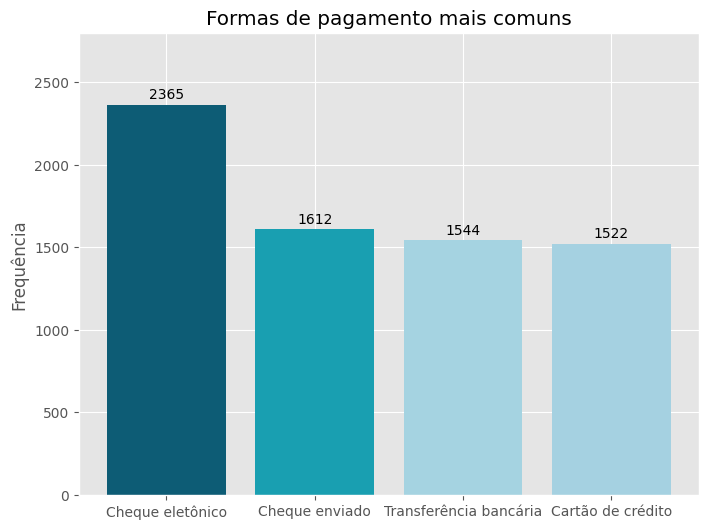

In [ ]:
plt.figure(figsize=[8,6])
barplot = plt.bar(x = list(paymant_method_count.index), height = list(paymant_method_count),
                      color =['#0d5c75','#199fb1', '#a5d3e1', '#a5d1e1'])

plt.bar_label(barplot, labels= list(paymant_method_count), padding=2)
plt.ylim(0, 2800)

plt.title("Formas de pagamento mais comuns")
plt.ylabel("Frequência")
plt.xticks(np.arange(4), ["Cheque eletônico", "Cheque enviado", 
                          "Transferência bancária", "Cartão de crédito"])


##MonthlyCharges

MontlyCharges - O valor cobrado do cliente mensalmente. Variável numérica contínua (float).

In [ ]:
df["MonthlyCharges"]

0       29.85
1       56.95
2       53.85
3       42.30
4       70.70
        ...  
7038    84.80
7039   103.20
7040    29.60
7041    74.40
7042   105.65
Name: MonthlyCharges, Length: 7043, dtype: float64

In [ ]:
#estatística geral
df["MonthlyCharges"].describe()

count   7,043.00
mean       64.76
std        30.09
min        18.25
25%        35.50
50%        70.35
75%        89.85
max       118.75
Name: MonthlyCharges, dtype: float64

A média de valor pago mensalmente pelos clientes é de 64,76.

In [ ]:
#Verificando para dados vazios
df["MonthlyCharges"].isna().sum()

0

In [ ]:
#Valores únicos
df["MonthlyCharges"].nunique()

1585

In [ ]:
#Curtose
df["MonthlyCharges"].kurtosis()

-1.2572596945495056

In [ ]:
#Assimetria
df["MonthlyCharges"].skew()

-0.22052443394398033

Assimetria negativa, valores concentram-se mais à esquerda da distribuição, sendo assim, mais ocorrências de valores acima da média.

In [ ]:
df["MonthlyCharges"].loc[df["MonthlyCharges"] <= 64.76].count()

3120

3120 clientes pagam por mês valor menor que a média.

In [ ]:
df["MonthlyCharges"].loc[df["MonthlyCharges"] > 64.76].count()

3923

3923 clientes pagam por mês valor maior que a média. 

Text(0, 0.5, 'Faixa de frequência')

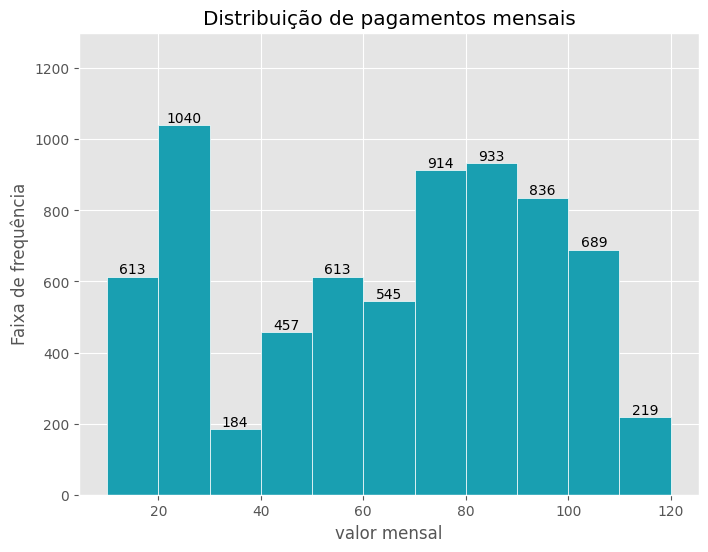

In [ ]:
#plotando a distribuição da pagamentos mensais
plt.figure(figsize=[8,6])
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120] #faixas de classe
counts, edges, bars = plt.hist(df["MonthlyCharges"], bins = bins,
                               edgecolor="white", color = ['#199fb1'])
plt.ylim(0, 1300)
plt.bar_label(bars)
plt.title('Distribuição de pagamentos mensais')
plt.xlabel('valor mensal')
plt.ylabel('Faixa de frequência')
  

  

Há varias faixas de valores de mensalidades, provavelmente relacionadas com os tipos de serviços contratados pelos clientes. 

**Pergunta:** Qual a contribuição dos diferentes serviços no valor da mensalidade?


Mensalidades mais altas (acima da média) são mais comuns como indica o coeficiente de assimetria da distribuição.

##TotalCharges

TotalCharges - O valor total cobrado do cliente. 

In [ ]:
df["TotalCharges"]

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object

In [ ]:
df["TotalCharges"].describe()

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object

O valor '  ' é o mais frequente. Há um problema.

In [ ]:
df["TotalCharges"].isnull().sum()

0

Os valores "vazios" não são necessariamente vazios. São espaços digitados talvez por erro.

In [ ]:
df.loc[df["TotalCharges"] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


Todos os clientes com valores totais "missing" têm também tenure = 0, ou seja, nenhum deles têm ao menos 1 mês completo de empresa. 

O input de 0 nos valores missing é o mais adequado? É consistente com o restante dos dados?

In [ ]:
#Copiando para input e análise
tc = df["TotalCharges"].copy()
tc

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object

In [ ]:
tc.replace(" ", "0", inplace=True)

In [ ]:
#Configurando para o tipo correto.
tc = tc.astype(float)

In [ ]:
tc.describe()

count   7,043.00
mean    2,279.73
std     2,266.79
min         0.00
25%       398.55
50%     1,394.55
75%     3,786.60
max     8,684.80
Name: TotalCharges, dtype: float64

In [ ]:
tc.kurtosis()

-0.22857980712373127

In [ ]:
#Os dados de valor total estão bem concentrados à direita (assimetria positiva)
tc.skew()

0.963234654832277

Text(0.5, 0, 'Valores totais')

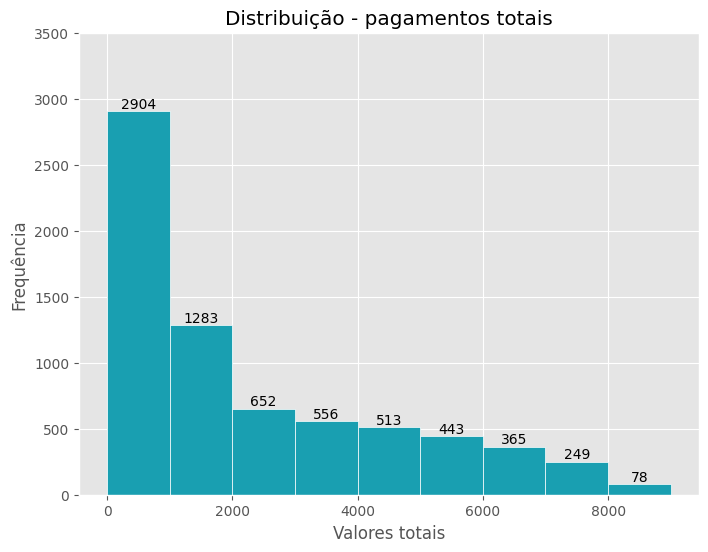

In [ ]:
#Plotando a distribuição com histograma
plt.figure(figsize = [8,6])
bins = [0,1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000] #faixas de classe
count, edges , bar = plt.hist(tc, bins = bins,
                              edgecolor="white", color = ['#199fb1']) 

plt.bar_label(bar)
plt.ylim(0,3500)
plt.title("Distribuição - pagamentos totais")
plt.ylabel("Frequência")
plt.xlabel("Valores totais")

## Análise multivariada

Está sessão destina-se a análise das features em contraste com a feature target (churn).

#Gênero x Churn

In [ ]:
gender_churn_taxa = df.groupby("gender")["Churn"].value_counts(1).unstack().round(2)*100
gender_churn_taxa

Churn,No,Yes
gender,,
Female,73.00,27.00
Male,74.00,26.00


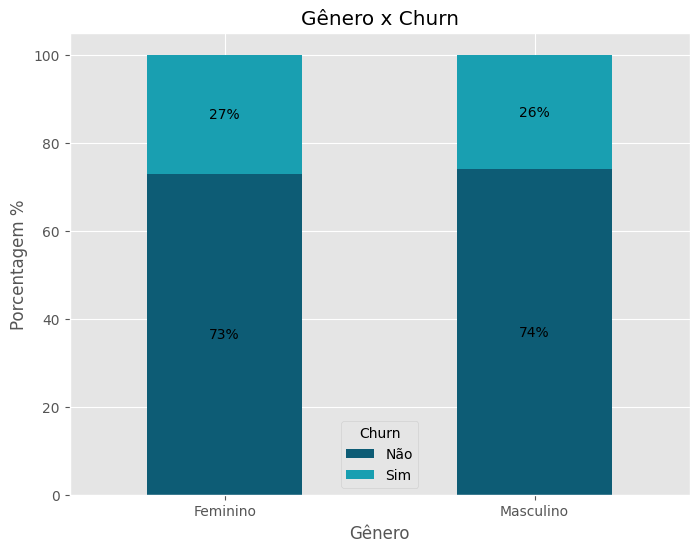

In [ ]:
#plotando
size = [8,6]
colors = ['#0d5c75','#199fb1']
crosstab_plot = gender_churn_taxa.plot(kind = 'bar', figsize = size,
                                       stacked = True, color = colors)


plt.title('Gênero x Churn')
plt.xticks(np.arange(2), ["Feminino", "Masculino"], rotation = 0)
plt.xlabel("Gênero")
plt.ylabel("Porcentagem %")
crosstab_plot.legend(title = 'Churn', labels = ['Não', 'Sim'])

for c in crosstab_plot.containers: 
  label = [str(int(v.get_height()))+'%' for v in c]
  crosstab_plot.bar_label(c, labels = label, label_type='center') #adicionando rótulos com bar_label



Aparentemente o gênero não é um fator que influencia o churn, uma vez que as taxas de churn entre os dois grupos são praticamente idênticas.

##Senior x Churn



In [ ]:
senior_churn_taxa = df.groupby("SeniorCitizen")["Churn"].value_counts(1).unstack().round(2)*100
senior_churn_taxa

Churn,No,Yes
SeniorCitizen,,
0,76.00,24.00
1,58.00,42.00


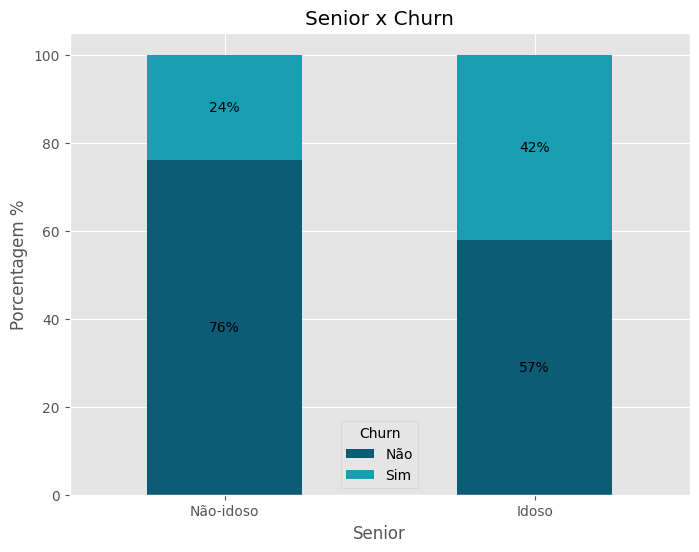

In [ ]:
#Criando o plot
bar_plot = senior_churn_taxa.plot(kind='bar', stacked = True, 
                                  figsize = size, color = colors)

#customizando
plt.title("Senior x Churn")
plt.xlabel("Senior")
plt.ylabel("Porcentagem %")
plt.xticks(np.arange(2), ["Não-idoso", "Idoso"], rotation = 0)
plt.legend(title = "Churn", labels = ["Não","Sim"])

#Adicionando labels
for c in bar_plot.containers:
  label = [str(int((v.get_height())))+'%' for v in c] #criando labels para os elementos nos dois containers
  bar_plot.bar_label(c, labels = label, label_type='center')

É nótavel a diferença entre as taxas de churn entre idosos e não-idosos. Idosos apresentam taxa de churn quase 2x mais alta.

##Partner x Dependents x Churn

Relação entre estado civil dos clientes e parentalidade com churn.

In [ ]:
#Qual a porcentagem de clientes com parceiros e filhos?
partner_dependents_taxa = df.groupby(["Partner"])["Dependents"].value_counts(1).unstack().round(2)*100
partner_dependents_taxa

Dependents,No,Yes
Partner,,
No,90.00,10.00
Yes,49.00,51.00


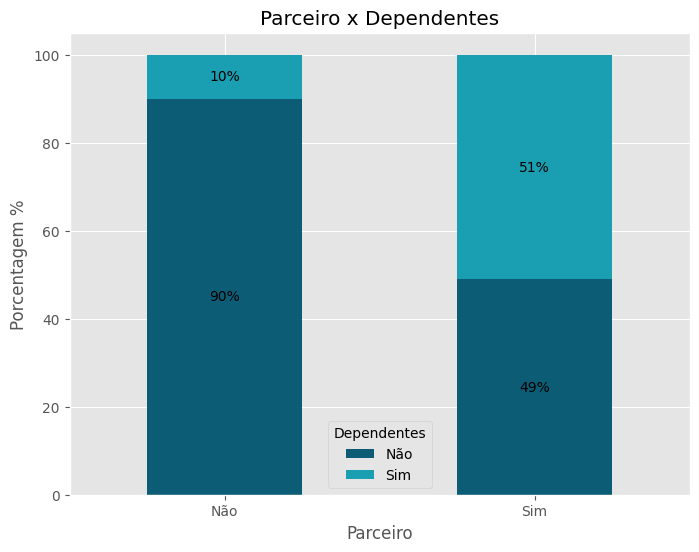

In [ ]:
#Plotando o gráfico
bar_plot = partner_dependents_taxa.plot(kind = 'bar', stacked = True, figsize = size,
                                       color = colors)
#customizando
plt.title("Parceiro x Dependentes")
plt.xlabel("Parceiro")
plt.ylabel("Porcentagem %")
plt.xticks(np.arange(2), ["Não", "Sim"], rotation = 0)
plt.legend(title = "Dependentes", labels = ["Não","Sim"])

#labels
for c in bar_plot.containers:
  label = [str(int(v.get_height()))+'%' for v in c]
  bar_plot.bar_label(c, labels = label, label_type = 'center' )

Praticamente metade dos clientes com parceiro também têm dependentes.

In [ ]:
partner_churn_taxa = df.groupby("Partner")["Churn"].value_counts(1).round(2).unstack()*100
partner_churn_taxa

Churn,No,Yes
Partner,,
No,67.00,33.00
Yes,80.00,20.00


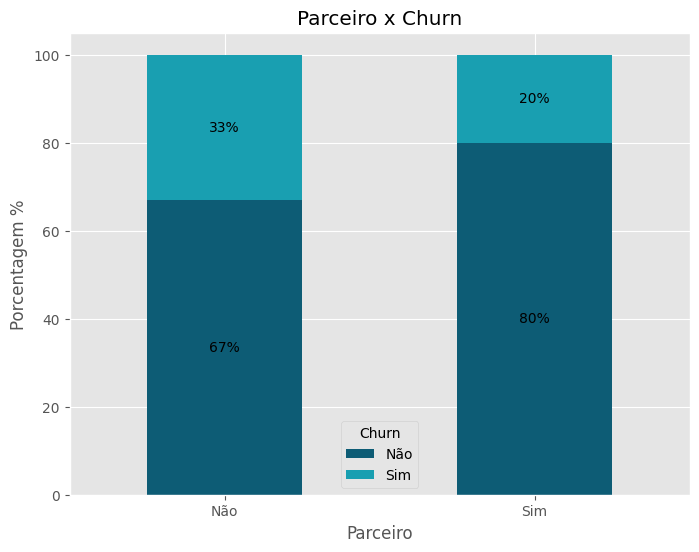

In [ ]:
bar_plot = partner_churn_taxa.plot(kind = 'bar', stacked = True,
                                   color = colors, figsize = size)

#customizando
plt.title("Parceiro x Churn")
plt.xlabel("Parceiro")
plt.ylabel("Porcentagem %")
plt.xticks(np.arange(2), ["Não", "Sim"], rotation = 0)
plt.legend(title = "Churn", labels = ["Não","Sim"])

#Labels
for c in bar_plot.containers:
  labels = [str(int(v.get_height()))+'%' for v in c]
  bar_plot.bar_label(c, labels = labels, label_type = 'center')

O churn tende a ser maior entre clientes solteiros, 33%(sem parceiro), do que em clientes com parceiros, 20%.

In [ ]:
dependentes_churn_taxa = df.groupby("Dependents")["Churn"].value_counts(1).unstack().round(2)*100
dependentes_churn_taxa

Churn,No,Yes
Dependents,,
No,69.00,31.00
Yes,85.00,15.00


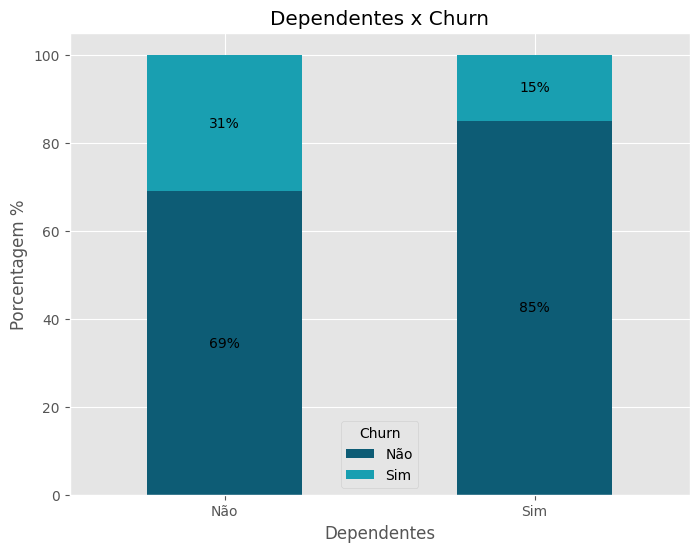

In [ ]:
#Plot
bar_plot = dependentes_churn_taxa.plot(kind = 'bar', stacked = True,
                                       color = colors, figsize = size)

#customizando
plt.title("Dependentes x Churn")
plt.xlabel("Dependentes")
plt.ylabel("Porcentagem %")
plt.xticks(np.arange(2), ["Não", "Sim"], rotation = 0)
plt.legend(title = "Churn", labels = ["Não","Sim"])

#adicionando rótulos às barras

for c in bar_plot.containers:
  labels = [str(int(v.get_height()))+'%' for v in c]
  bar_plot.bar_label(c, labels = labels, label_type = 'center')

Interessante resultado, a taxa de churn entre clientes sem dependentes é quase 2 vezes maior do que entre clientes com dependentes, 31% a 15%, respectivamente.

##Resumo geral - Gênero, parceiro e dependentes.

Pelo que é possível notar no que diz respeito ao padrão demográfico dos clientes, aparentemente, os perfís **solteiro, sem dependentes e idoso** apresentam maiores taxas de churn quando comparados a clientes com parceiros, com dependentes e não-idosos. Não foram notadas diferenças relevantes quando ao sexo.

##Relação Tenure x Churn

Text(0, 0.5, 'Tenure')

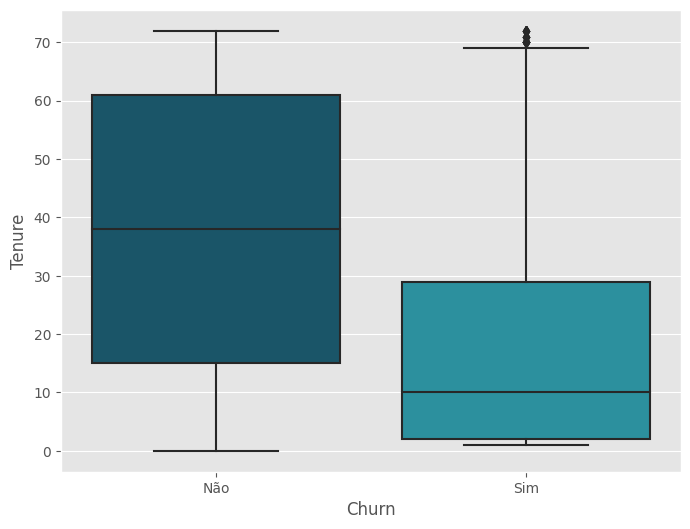

In [ ]:
plt.figure(figsize = [8,6])
sns.boxplot(data=df, x=df.Churn, y=df.tenure, palette = colors)
plt.xticks(np.arange(2), ["Não", "Sim"])
plt.ylabel("Tenure")


É possível identificar que clientes que abandonam o serviço (churn positivo) tendem a ficar por menos meses. Aparentemente, esse é o comportamento médido desses clientes.

In [ ]:
#Quantis e intervalo interquartilico
Q1 = df["tenure"].loc[df["Churn"] == 'Yes'].quantile(0.25)
Q3 = df["tenure"].loc[df["Churn"] == 'Yes'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
#Outlier
Outlier = Q3 + 1.5*IQR
Outlier

69.5

Valores acima de 69.5 são os outliers presentes no boxplot.

In [ ]:
#Quantos outliers temos na distribuição?
(df["tenure"].loc[df["Churn"] == 'Yes'] > 69.5).sum()

23

In [ ]:
#Qual a proporção de cleintes churn positivo e negativo?
df["Churn"].value_counts(1).round(2)*100

No    73.00
Yes   27.00
Name: Churn, dtype: float64

Há uma predominância de casos de churn negativo no conjunto de dados, ou seja, a maior parte dos clientes (73%) não abandonaram o serviço, a ocorrência, portanto, de clientes que abandonaram é bastante menor (27%).

Text(0.5, 0, 'Meses')

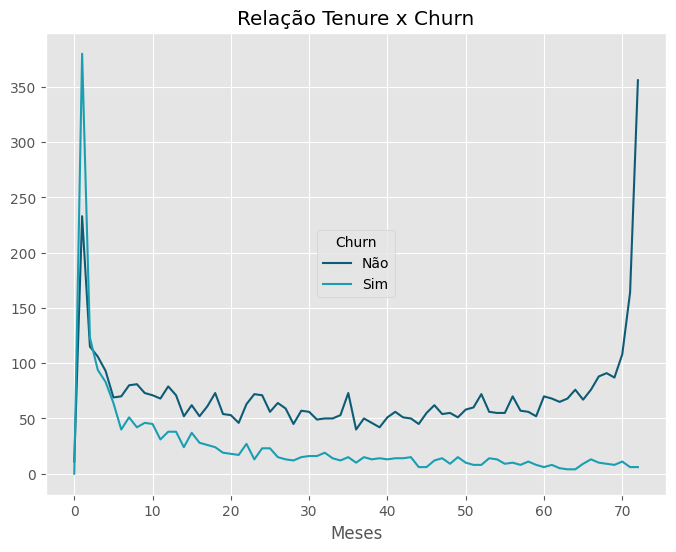

In [ ]:
Churn_tenure = pd.crosstab(df.tenure, df.Churn).plot(figsize = size, color = colors)

plt.title("Relação Tenure x Churn")
plt.legend(title = "Churn", labels = ["Não","Sim"], loc = 'center')
plt.xlabel("Meses")

Como visto anteriormente, a medida que o cliente permanece por mais meses o churn parece tender a diminuir. Os primeiros meses parecem serem críticos no que diz respeito a ocorrência de churn, talvez estratégias de retenção de cliente nessa etapa seja interessante visando a diminuição da taxa de churn.

In [ ]:
tenure_churn = df["tenure"].loc[df["Churn"] == 'Yes']

In [ ]:
df["tenure"].loc[df["Churn"] == 'Yes']

2        2
4        2
5        8
8       28
13      49
        ..
7021    12
7026     9
7032     1
7034    67
7041     4
Name: tenure, Length: 1869, dtype: int64

In [ ]:
#Contagem de observações que satisfazem a condição loc
tenure_churn.count()

1869

In [ ]:
x_list = np.linspace(tenure_churn.min(), tenure_churn.max(), 1869) #contrustução dos pontos x para plot
y_list = norm.norm.pdf(x_list, loc=tenure_churn.median(), scale=tenure_churn.std()) #calculando função densidade de probabilidade normalizada

Text(0.5, 0, 'Distribuição - Churn')

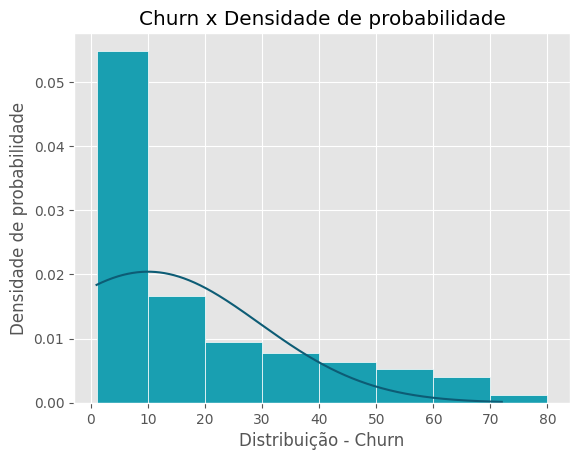

In [ ]:
bins = [1, 10, 20, 30, 40, 50, 60, 70,80]
plt.plot(x_list,y_list, color ='#0d5c75' )
df["tenure"].loc[df["Churn"] == 'Yes'].hist(bins = bins, density = True,
                                            edgecolor = 'white', color = ['#199fb1'])    

plt.title("Churn x Densidade de probabilidade")
plt.ylabel("Densidade de probabilidade")
plt.xlabel("Distribuição - Churn")  

Seguindo a tendência já identificada, os primeiros meses do cliente acumulam maior probabilidade de churn, que decai a medida que se extende a permanência.

##Serviços contratados x Churn

Nessa etapa a análise se concentrará na relação entre os diferentes tipos de serviços contratados pelos clientes e o churn. Buscaremos também investigar qual a contribuição desses serviços no faturamento mensal.

#PhoneService x Churn



In [ ]:
PS_churn = df.groupby("PhoneService")["Churn"].value_counts(1).round(2).unstack()*100
PS_churn

Churn,No,Yes
PhoneService,,
No,75.00,25.00
Yes,73.00,27.00


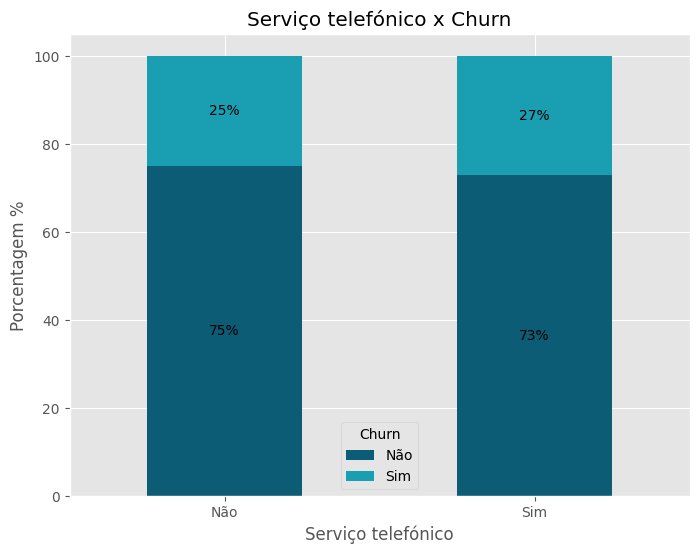

In [ ]:
#plot
bar_plot = PS_churn.plot(kind = 'bar', stacked = True,
                         figsize = size, color = colors)

#customizando
plt.title("Serviço telefónico x Churn")
plt.xlabel("Serviço telefónico")
plt.ylabel("Porcentagem %")
plt.xticks(np.arange(2), ["Não", "Sim"], rotation = 0)
plt.legend(title = "Churn", labels = ["Não","Sim"])

#adicionando rótulos
for c in bar_plot.containers:
  labels = [str(int(v.get_height()))+'%' for v in c]
  plt.bar_label(c, labels = labels, label_type = 'center')

Ter serviço telefónico não parece ser tão impactante no que diz respeito ao churn.

##MultipleLines x Churn


In [ ]:
mtl_churn = df.groupby("MultipleLines")["Churn"].value_counts(1).round(2).unstack()*100
mtl_churn

Churn,No,Yes
MultipleLines,,
No,75.00,25.00
No phone service,75.00,25.00
Yes,71.00,29.00


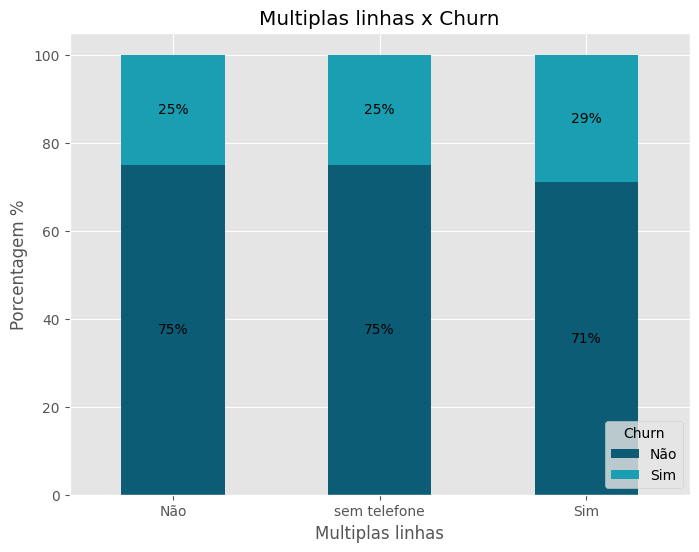

In [ ]:
bar_plot = mtl_churn.plot(kind = 'bar', stacked = True,
                          figsize = size, color = colors)

#customizando
plt.title("Multiplas linhas x Churn")
plt.xlabel("Multiplas linhas")
plt.ylabel("Porcentagem %")
plt.xticks(np.arange(3), ["Não", "sem telefone", "Sim"], rotation = 0)
plt.legend(title = "Churn", labels = ["Não","Sim"], loc = 'lower right')

for c in bar_plot.containers:
  labels = [str(int(v.get_height()))+"%" for v in c]
  plt.bar_label(c, labels = labels, label_type='center')

Clientes que não assinaram o serviço de múltiplas linhas têm taxa de churn menor quando comparado aos clientes que têm esse tipo de serviço. Clientes sem serviço telefónico apresentam a mesma taxa de churn que os clientes sem múltiplas linhas.

##Internet Service x Churn

In [ ]:
IS_churn_taxa = df.groupby("InternetService")["Churn"].value_counts(1).round(2).unstack()*100
IS_churn_taxa

Churn,No,Yes
InternetService,,
DSL,81.00,19.00
Fiber optic,58.00,42.00
No,93.00,7.00


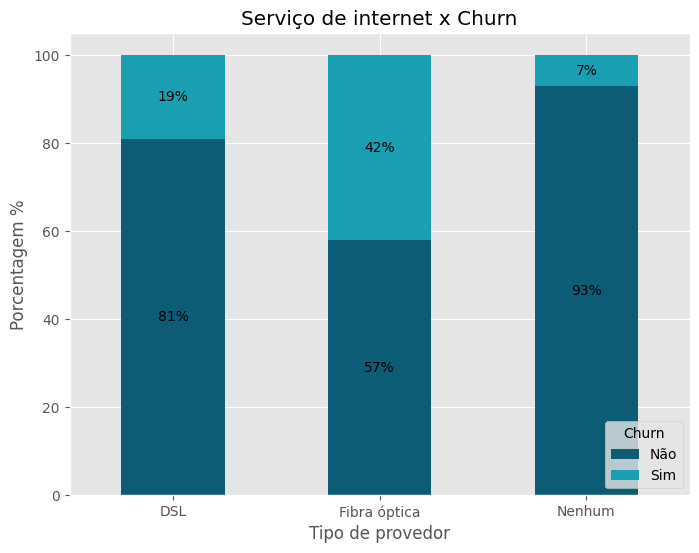

In [ ]:
bar_plot = IS_churn_taxa.plot(kind = 'bar', stacked = True,
                          figsize = size, color = colors)

#customizando
plt.title("Serviço de internet x Churn")
plt.xlabel("Tipo de provedor")
plt.ylabel("Porcentagem %")
plt.xticks(np.arange(3), ["DSL", "Fibra óptica", "Nenhum"], rotation = 0)
plt.legend(title = "Churn", labels = ["Não","Sim"], loc = 'lower right')

for c in bar_plot.containers:
  labels = [str(int(v.get_height()))+"%" for v in c]
  plt.bar_label(c, labels = labels, label_type='center')

Dentre os tipos de serviços de internet, os clientes com provedor DSL têm taxa de churn menor(19%) quando comparados aos clientes com fibra óptica, cuja taxa de churn é bem maior (43%).

##Online Security x Churn

In [ ]:
OS_churn_taxa = df.groupby("OnlineSecurity")["Churn"].value_counts(1).round(2).unstack()*100
OS_churn_taxa

Churn,No,Yes
OnlineSecurity,,
No,58.00,42.00
No internet service,93.00,7.00
Yes,85.00,15.00


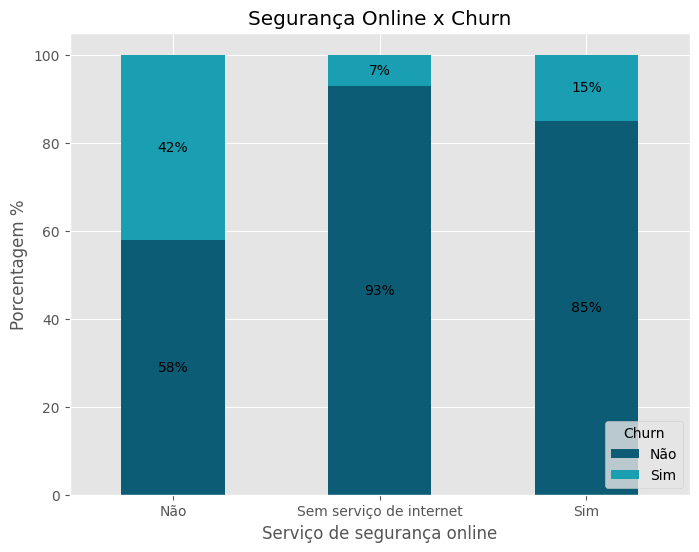

In [ ]:
os_bar_plot = OS_churn_taxa.plot(kind = 'bar', stacked = True,
                          figsize = size, color = colors)

#customizando
plt.title("Segurança Online x Churn")
plt.xlabel("Serviço de segurança online")
plt.ylabel("Porcentagem %")
plt.xticks(np.arange(3), ["Não", "Sem serviço de internet", "Sim"], rotation = 0)
plt.legend(title = "Churn", labels = ["Não","Sim"], loc = 'lower right')

for c in os_bar_plot.containers:
  labels = [str(int(v.get_height().round(2)))+"%" for v in c]
  plt.bar_label(c, labels = labels, label_type='center')

Clientes sem serviço de segurança online têm mais que o dobro (42% a 15%) de taxa de churn, ter serviço de segurança online parece ser um ponto bastante relevante no que diz respeito ao churn no presente conjunto de dados.

##Online Backup x Churn

In [444]:
OB_churn_taxa = df.groupby("OnlineSecurity")["Churn"].value_counts(1).round(2).unstack()*100
OB_churn_taxa 

Churn,No,Yes
OnlineSecurity,,
No,58.00,42.00
No internet service,93.00,7.00
Yes,85.00,15.00


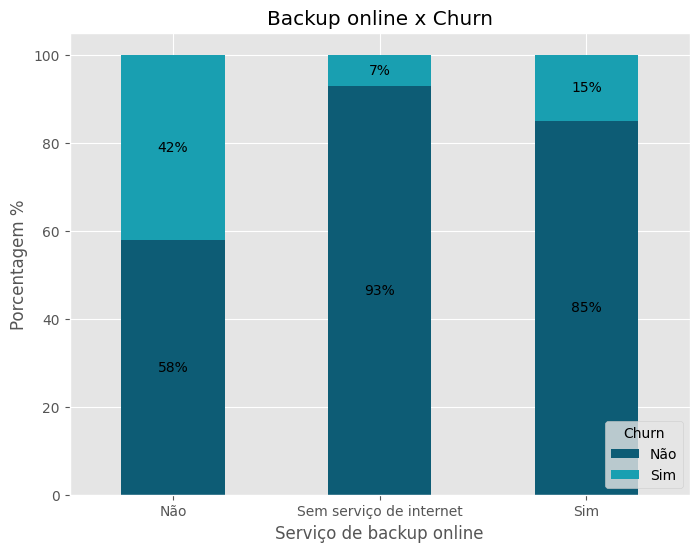

In [448]:
bar_plot = OB_churn_taxa.plot(kind = 'bar', stacked = True,
                          figsize = size, color = colors)

#customizando
plt.title("Backup online x Churn")
plt.xlabel("Serviço de backup online")
plt.ylabel("Porcentagem %")
plt.xticks(np.arange(3), ["Não", "Sem serviço de internet", "Sim"], rotation = 0)
plt.legend(title = "Churn", labels = ["Não","Sim"], loc = 'lower right')

for c in bar_plot.containers:
  labels = [str(int(v.get_height().round(2)))+"%" for v in c]
  plt.bar_label(c, labels = labels, label_type='center')

A tendência é a mesma do que se observou na relação segurança online e churn, temos uma taxa de churn mais que duas vezes maior em clientes sem serviço de backup online comparado ao que tem, 42% a 15% respectivamente.

In [ ]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')